# Data augmentation

In [1]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices("GPU")
for gp in gpus:
    tf.config.experimental.set_memory_growth(gp, True)

Num GPUs Available:  1


# loading data

## useful functions

In [11]:
IMG_SIZE = 200
BATCH_SIZE = 32

In [12]:
def process_image(image_path,img_size=IMG_SIZE):
    '''
    Function takes as an input a string called image_path and optionally img_size,
    it gets an image from the path, 
    turning it into a tensor and resizing it to the square, img_size x img_size.
    '''
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image,channels=3) # turning into a tensor
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize(image,size=[img_size,img_size]) # resizing
    return image

def get_tuples(image_path,label):
    """
    returns (image,label) tuples,
    where label is 0 when image is fake and 1 when it's real
    """
    image = process_image(image_path,IMG_SIZE)
    return (image,label)
def get_batch(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
    """
    Create batches of data out of image (X - filepath) and label (y - labels) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    side note: it's easier to shuffle filepaths rather than whole images
    """
    if test_data:
        print('Creating test data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # every filepath as new example
        data_batch = data.map(process_image).batch(BATCH_SIZE) # from filename to image, then get a batch
        return data_batch
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        data_batch = data.map(get_tuples).batch(BATCH_SIZE)
        return data_batch
    else:
        print("Creating training data batches...")

        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))

        # shuffling pathnames and labels is far easier than shuffling images
        data = data.shuffle(buffer_size=len(X))

        # get (image,label) tuples
        data = data.map(get_tuples)

        # Turning into batch
        data_batch = data.batch(batch_size)

        return data_batch
def get_tuples(image_path,label):
    """
    returns (image,label) tuples,
    where label is 0 when image is fake and 1 when it's real
    """
    image = process_image(image_path,IMG_SIZE)
    
    return (image,label)
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch.
    """
    # Setup the figure
    plt.figure(figsize=(10, 10))
    for i in range(24):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(labels[i])
        # Turn the grid lines off
        plt.tight_layout()
        plt.axis("off")


In [4]:
import re
# importing dataset1

folder_path = './augmented_images'
X,y = [],[]
images,labels = [],[]

for filename in os.listdir(folder_path):
    label = re.findall('^(\d{1,3})\_',filename) # searching for age
    label = int(label[0]) # extracting it as int
    
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(folder_path, filename)
        
        # image
        X.append(image_path)

        # label
        y.append(label)
        labels.append(label)

In [5]:
print(len(X),len(y))
print(len(images))

37903 37903
0


In [44]:
X_batch = get_batch(X,y)

Creating training data batches...


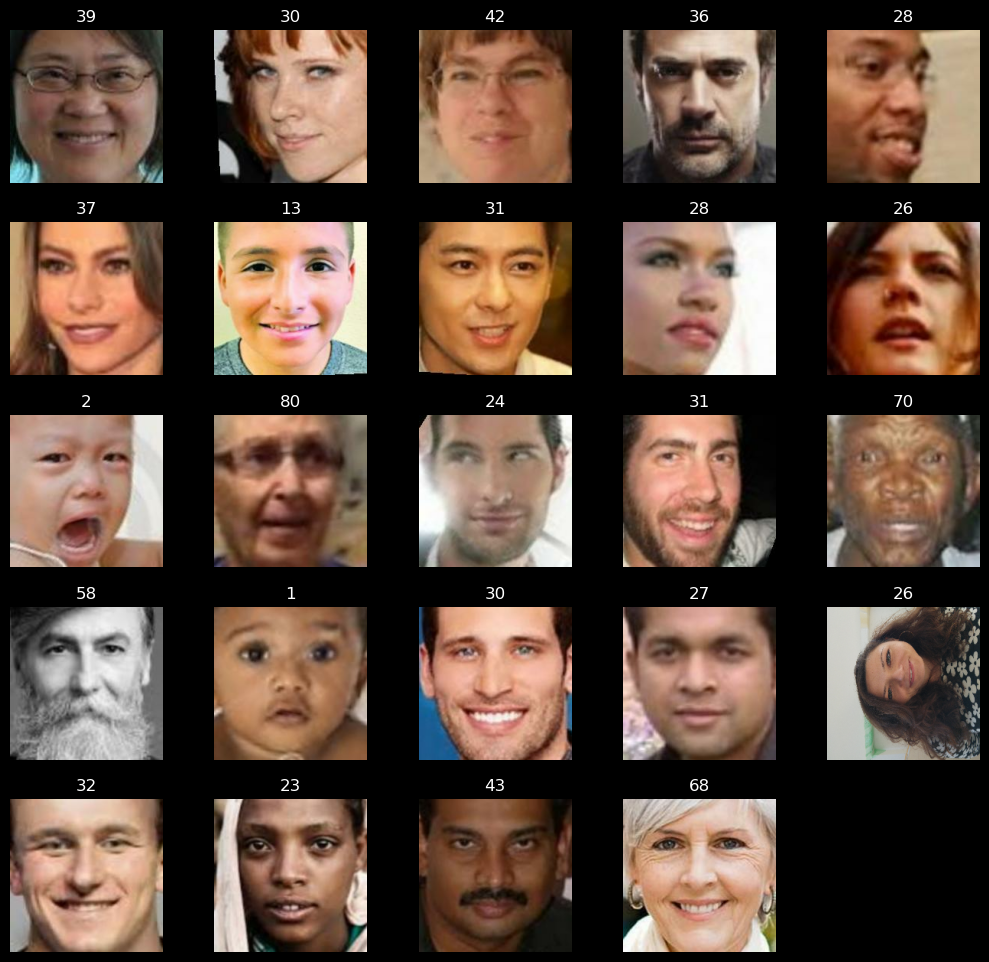

In [45]:
images, labels = next(X_batch.as_numpy_iterator())
show_25_images(images,labels)

# Generating images

In [46]:
# Inicjalizacja generatora danych
datagen = ImageDataGenerator(
    rotation_range=20,  # Zakres kątów obrotu w stopniach
    width_shift_range=0.1,  # Przesunięcie w poziomie
    height_shift_range=0.1,  # Przesunięcie w pionie
    shear_range=0.3,  # Przekształcenie ścinające
    zoom_range=0.3,  # Zakres skalowania
    horizontal_flip=True,  # Odbicie lustrzane
    fill_mode='nearest'  # Tryb wypełniania pikseli po transformacji
)

# Przykładowe zastosowanie do obrazów (X to dane treningowe, Y to etykiety)
datagen.fit(images)

# Generowanie zmodyfikowanych obrazów
augmented_data = datagen.flow(images,labels, batch_size=BATCH_SIZE)

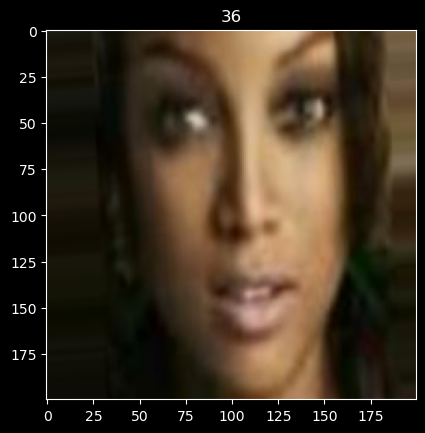

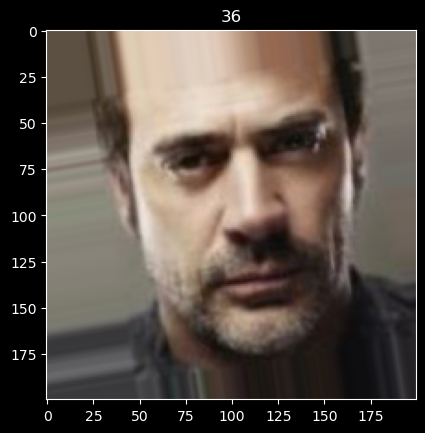

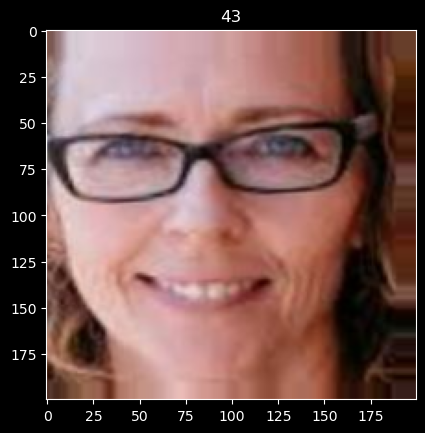

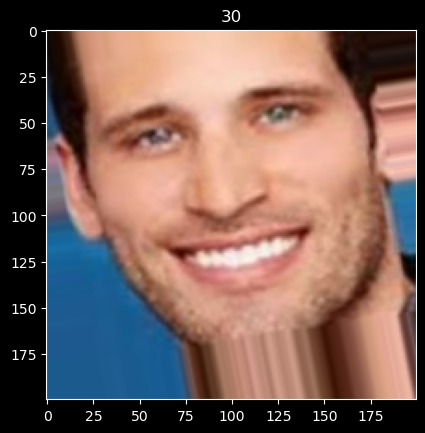

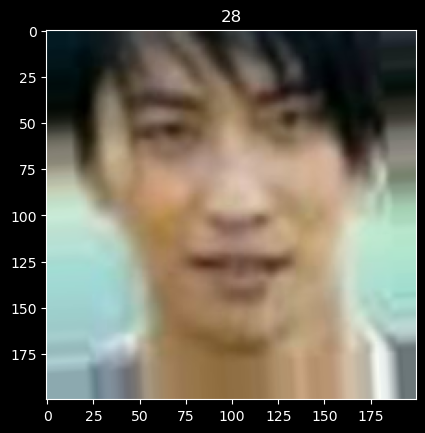

In [48]:
example = next(augmented_data)
plt.style.use('dark_background')
for i in range(5):
    plt.imshow(example[0][i])
    plt.title(example[1][i])
    plt.show()

# Saving images

In [ ]:
save_dir = "augmented_images"
plt.style.use('dark_background')
c = 0
for batch in augmented_data:
    for i in range(BATCH_SIZE):
        image,label = batch[0][i],batch[1][i]
        plt.imshow(image)  # show image
        plt.axis('off')  # 
        plt.savefig(os.path.join(save_dir, f"{label}_augmented_image_{c}.png"))  # Zapis obrazu
        plt.close()  # Zamknięcie wykresu
        c+=1

In [ ]:
print(c)